# Charts for bus service opportunities by tract and CalEnviroScreen / Density Scores

* Density and CalEnviroScreen both grouped as low/med/high
* Provide some charts to accompany maps
* Heatmaps to show distribution?
* Scatterplot of pop density vs service density

In [1]:
# -- DO ONCE in terminal
# !conda install --yes -c conda-forge --file conda-requirements.txt

# npm worked a bit, but now has error using altair_saver
# https://stackoverflow.com/questions/62601904/altair-saver-valueerror-unsupported-format-png
#!npm install vega-lite vega-cli canvas

In [1]:
import altair as alt
import altair_saver
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import prep_data
import map_utils
import tract_utils

from IPython.display import display, SVG

alt.themes.enable("fivethirtyeight")
alt.data_transformers.enable('default', max_rows=10_000)
alt.renderers.enable('altair_saver', fmts=['vega-lite'])

pd.set_option("display.max_rows", 20)        

In [2]:
df = prep_data.generate_stop_times_tract_data()

# Address small numbers issue
df = df[df.Population > 10].reset_index(drop=True)

## Heatmap by Equity and Density Groups

In [3]:
sum_cols = ["stop_id", "itp_id", "Population", "num_arrivals"]
count_cols = ["Tract"]
nunique_cols = []

t1 = tract_utils.aggregate_by_tract (df, 
                                     group_cols = ["avg_density_score", "equity_group"], 
                                     sum_cols = sum_cols, 
                                     count_cols = count_cols, 
                                     nunique_cols = nunique_cols
                                    ).astype("int")

LEGEND_LABELS = {
    1: "Low",
    2: "Med",
    3: "High"
}

LEGEND_ORDER = list(LEGEND_LABELS.values())

DENOM = 1_000
t1 = t1[t1.avg_density_score > 0].assign(
    arrivals_per_1k = (t1.num_arrivals / t1.Population) * DENOM,
    stops_per_1k = (t1.stop_id / t1.Population) * DENOM,
    #equity_group = t1.equity_group.map(LEGEND_LABELS),
    avg_density_score = t1.avg_density_score.map(LEGEND_LABELS),
)   


t1.head()

,avg_density_score,equity_group,Population,itp_id,num_arrivals,stop_id,Tract,arrivals_per_1k,stops_per_1k
0,Low,1,4822184,888,94101,5842,1044,19.514187,1.211484
1,Med,1,6876798,1555,361820,12828,1431,52.614603,1.865403
2,High,1,1126230,309,176160,2756,240,156.415652,2.447102
3,High,2,2134481,675,316683,5281,434,148.365340,2.474138
4,High,3,3407655,1520,548751,10045,741,161.034788,2.947775


In [12]:
t1.sort_values(["equity_group", "avg_density_score"])[["avg_density_score", "equity_group", "Tract", "arrivals_per_1k"]]

,avg_density_score,equity_group,Tract,arrivals_per_1k
2,High,1,240,156.415652
0,Low,1,1044,19.514187
1,Med,1,1431,52.614603
3,High,2,434,148.365340
7,Low,2,549,19.524353
6,Med,2,1660,68.255807
4,High,3,741,161.034788
8,Low,3,284,16.404449
5,Med,3,1620,97.880119


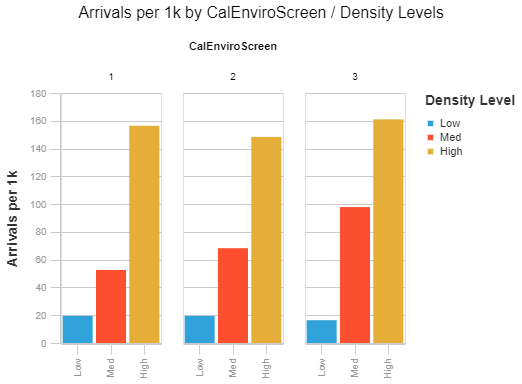

In [11]:
bar = (alt.Chart(t1)
 .mark_bar()
 .encode(
     x=alt.X("avg_density_score:N", 
             axis=alt.Axis(title=""), 
             scale=alt.Scale(domain=LEGEND_ORDER)
            ),
     y=alt.Y("arrivals_per_1k:Q",
             axis=alt.Axis(title="Arrivals per 1k")
            ),
     column=alt.Column("equity_group:N", title="CalEnviroScreen", 
                      ),
     color=alt.Color("avg_density_score:N", title="Density Level", 
                    scale=alt.Scale(domain=LEGEND_ORDER, 
                                    range=map_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS
                                   )
                    )
 )
)


bar = (map_utils.preset_chart_config(bar)
       .properties(title="Arrivals per 1k by CalEnviroScreen / Density Levels", 
                  width = map_utils.chart_width*0.25)
)

bar
#bar.save("./img/arrivals_per_1k_bar.png")

In [6]:
def pivot_get_counts(df, index_col, group_col, value_col):
    df2 = df.pivot(index = index_col, 
                   columns = group_col, 
                   values = value_col)
    return df2

index_col = "avg_density_score"
group_col = "equity_group"


def make_heatmap(df, cmap, chart_title, xtitle, ytitle):
    chart = (sns.heatmap(df, cmap=cmap)
             .set(title=chart_title, xlabel=xtitle, ylabel=ytitle,
                 )
    )

    return chart

In [7]:
LOOP_DICT = {
    "Tract": "Tracts",
    "stop_id": "Bus Stops",
    "itp_id": "Operators",
    "arrivals_per_1k": "Arrivals per 1k",
    "stops_per_1k": "Stops per 1k",
} 

#plt.gcf().set_size_inches(1, 1)

for key, value in LOOP_DICT.items():
    subset_df = t1
    pivot_df = pivot_get_counts(subset_df, index_col, group_col, key)
    pivot_df = pivot_df.reindex(index=LEGEND_ORDER)
    
    print(key)
    display(pivot_df)
    #display(pivot_df.sort_index(axis=0, ascending=True))
    #display(pivot_df.reindex(index=LEGEND_ORDER))
    
    chart = make_heatmap(pivot_df, cmap="Blues", 
                 chart_title=(f"{value} by CalEnviroScreen" "\n and Density Levels"),
                 xtitle="CalEnviroScreen", ytitle="Job/Pop Density"   
                 )

    plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)
    plt.close()
    


Tract


equity_group,1,2,3
avg_density_score,,,
Low,1044,549,284
Med,1431,1660,1620
High,240,434,741


/tmp/ipykernel_5901/867900099.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stop_id


equity_group,1,2,3
avg_density_score,,,
Low,5842,3369,1586
Med,12828,18572,23612
High,2756,5281,10045


/tmp/ipykernel_5901/867900099.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


itp_id


equity_group,1,2,3
avg_density_score,,,
Low,888,470,223
Med,1555,2276,2949
High,309,675,1520


/tmp/ipykernel_5901/867900099.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


arrivals_per_1k


equity_group,1,2,3
avg_density_score,,,
Low,19.514187,19.524353,16.404449
Med,52.614603,68.255807,97.880119
High,156.415652,148.365340,161.034788


/tmp/ipykernel_5901/867900099.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stops_per_1k


equity_group,1,2,3
avg_density_score,,,
Low,1.211484,1.132124,0.952392
Med,1.865403,2.236730,2.964303
High,2.447102,2.474138,2.947775


/tmp/ipykernel_5901/867900099.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


## Scatterplot of pop density vs service density

In [8]:
y_col = "arrivals_per_1k:Q"
group_col = "equity_group:N"
tooltip=['Tract', 'ZIP', 'County', 'City', 
                 'pop_sq_mi', 'arrivals_per_1k', 'equity_group']

def make_scatterplot(df, x_col, y_col, group_col, tooltip_list, chart_title):
    
    # Interactive chart should be centered near where 95th percentile data is
    # There are outliers...but let's not have it so zoomed out
    
    def colname_label(col):
        colname = col.split(":")[0]
        coltitle = colname.replace('_', ' ')
        return colname, coltitle
    
    x_colname, x_title = colname_label(x_col)
    y_colname, y_title = colname_label(y_col)
    
    MAX_X = df[x_colname].quantile(q=0.95)
    MAX_Y = df[y_colname].quantile(q=0.95)
    
    chart = (
        alt.Chart(df[((df[x_colname] > 0) & (df[y_colname] > 0))])
        .mark_point(size=30, fillOpacity=0.8)
        .encode(
            x=alt.X(x_col, 
                    scale=alt.Scale(domain=(0, MAX_X)), 
                    axis=alt.Axis(title=f"{x_title}")
                   ),
            y=alt.Y(y_col, 
                    scale=alt.Scale(domain=(0, MAX_Y)),
                    axis=alt.Axis(title=f"{y_title}")
                   ),
            color=group_col,
            tooltip=tooltip_list
        )
    )
    
    chart = (map_utils.preset_chart_config(chart)
             .properties(title=f"{chart_title}")
             .interactive()
            )
    
    return chart

In [9]:
x_col = "pop_sq_mi:Q"

# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.avg_density_score > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title="Pop Density vs Service Density")
c.save("./img/scatter_popdensity_servicedensity.html")

In [10]:
x_col = "jobs_sq_mi:Q"
# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.avg_density_score > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title = "Job Density vs Service Density")
c.save("./img/scatter_jobdensity_servicedensity.html")